In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# URL der Datenquelle
url = "https://www.eco-visio.net/api/aladdin/1.0.0/pbl/publicwebpageplus/data/100126474?idOrganisme=4586&idPdc=100126474&interval=3&flowIds=100126474"

# Daten von der URL abrufen
response = requests.get(url)
data = response.json()

# JSON-Daten in ein DataFrame umwandeln
df = pd.DataFrame(data, columns=["date", "value"])

# Datum in Datetime-Format ohne Uhrzeit konvertieren
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

# Stunden von 0 bis 23 für jeden Tag hinzufügen
df["hour"] = df.groupby("date").cumcount()

# Kombinieren von Datum und Stunde in eine neue Spalte "datetime"
df["Datetime"] = df["date"] + pd.to_timedelta(df["hour"], unit="H")

# "datetime" als Index setzen und unnötige Spalten entfernen
df.set_index("Datetime", inplace=True)
df.drop(columns=["date", "hour"], inplace=True)

In [2]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112949 entries, 2012-04-25 00:00:00 to 2025-03-29 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   value   112949 non-null  int64
dtypes: int64(1)
memory usage: 1.7 MB


<AxesSubplot:xlabel='Datetime'>

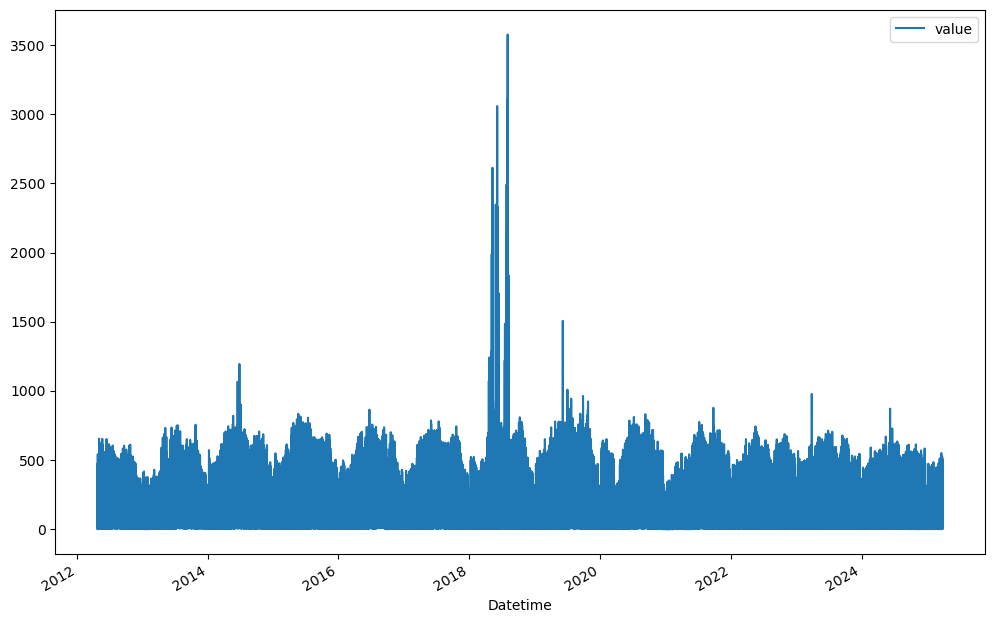

In [4]:
df.plot(figsize=(12,8))

In [5]:
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert('Europe/Berlin')

In [6]:
df.rename(columns={"value": "bike_count"}, inplace = True)
df.rename(columns={"value": "neue_spalte"}, inplace = True)

df.dropna(inplace=True)

nan_count = df['bike_count'].isna().sum()
nan_indices = df[df['bike_count'].isna()].index

full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
missing_hours = full_range.difference(df.index)

duplicates = df[df.duplicated()]


print(f"NaN count in target column: {nan_count}")
print("Index", nan_indices)
print("Missing hours:", missing_hours)
print("Duplicates:", duplicates)


NaN count in target column: 0
Index DatetimeIndex([], dtype='datetime64[ns, Europe/Berlin]', name='Datetime', freq=None)
Missing hours: DatetimeIndex(['2013-04-01 01:00:00+02:00', '2014-03-31 01:00:00+02:00',
               '2015-03-30 01:00:00+02:00', '2016-03-28 01:00:00+02:00',
               '2017-03-27 01:00:00+02:00', '2018-03-26 01:00:00+02:00',
               '2019-04-01 01:00:00+02:00', '2020-03-30 01:00:00+02:00',
               '2021-03-29 01:00:00+02:00', '2022-01-05 01:00:00+01:00',
               ...
               '2024-12-27 20:00:00+01:00', '2024-12-27 21:00:00+01:00',
               '2024-12-27 22:00:00+01:00', '2024-12-27 23:00:00+01:00',
               '2024-12-28 00:00:00+01:00', '2024-12-28 20:00:00+01:00',
               '2024-12-28 21:00:00+01:00', '2024-12-28 22:00:00+01:00',
               '2024-12-28 23:00:00+01:00', '2024-12-29 00:00:00+01:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=379, freq=None)
Duplicates:                           

#### Missing Values

In [7]:
start_date = df.index.min()
end_date = df.index.max()

all_hours = pd.date_range(start=start_date, end=end_date, freq='H')

missing_hours = all_hours.difference(df.index)

missing_count = len(missing_hours)

print(missing_count)
print(missing_hours)

379
DatetimeIndex(['2013-04-01 01:00:00+02:00', '2014-03-31 01:00:00+02:00',
               '2015-03-30 01:00:00+02:00', '2016-03-28 01:00:00+02:00',
               '2017-03-27 01:00:00+02:00', '2018-03-26 01:00:00+02:00',
               '2019-04-01 01:00:00+02:00', '2020-03-30 01:00:00+02:00',
               '2021-03-29 01:00:00+02:00', '2022-01-05 01:00:00+01:00',
               ...
               '2024-12-27 20:00:00+01:00', '2024-12-27 21:00:00+01:00',
               '2024-12-27 22:00:00+01:00', '2024-12-27 23:00:00+01:00',
               '2024-12-28 00:00:00+01:00', '2024-12-28 20:00:00+01:00',
               '2024-12-28 21:00:00+01:00', '2024-12-28 22:00:00+01:00',
               '2024-12-28 23:00:00+01:00', '2024-12-29 00:00:00+01:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=379, freq=None)


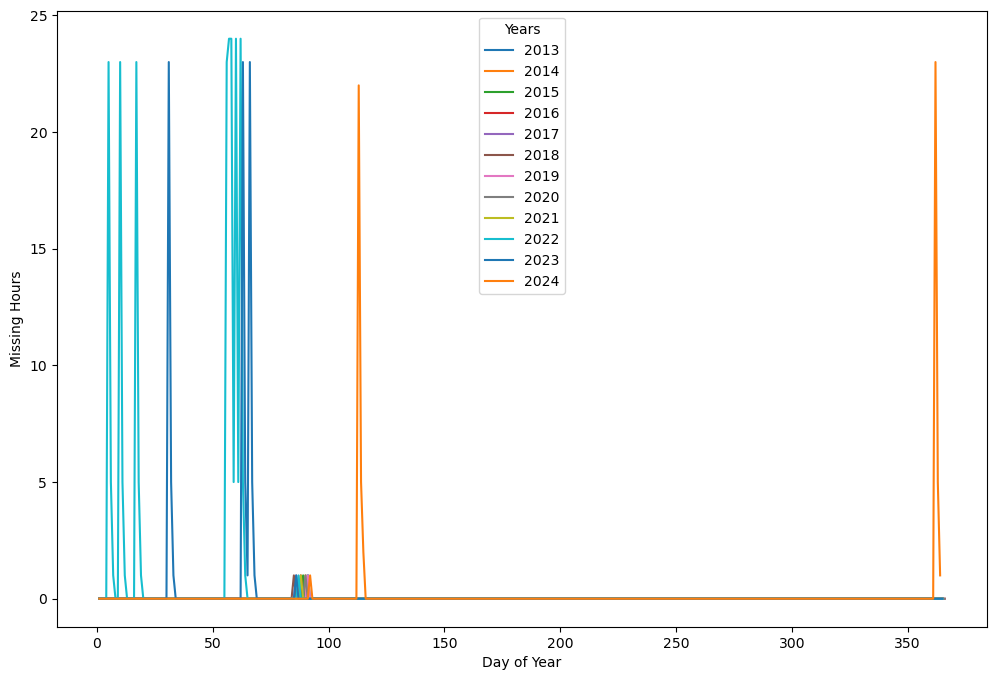

In [8]:
start_date = df.index.min()
end_date = df.index.max()

all_hours = pd.date_range(start=start_date, end=end_date, freq='H')

missing_hours = all_hours.difference(df.index)

missing_df = pd.DataFrame(index=missing_hours, data={'missing': 1})
missing_per_day = missing_df.resample('D').sum()

plt.figure(figsize=(12, 8))

for year in range(start_date.year, end_date.year + 1):
    yearly_data = missing_per_day[missing_per_day.index.year == year]
    if not yearly_data.empty:
        plt.plot(yearly_data.index.dayofyear, yearly_data['missing'], label=str(year))

plt.xlabel('Day of Year')
plt.ylabel('Missing Hours')
plt.legend(title="Years")
plt.show()

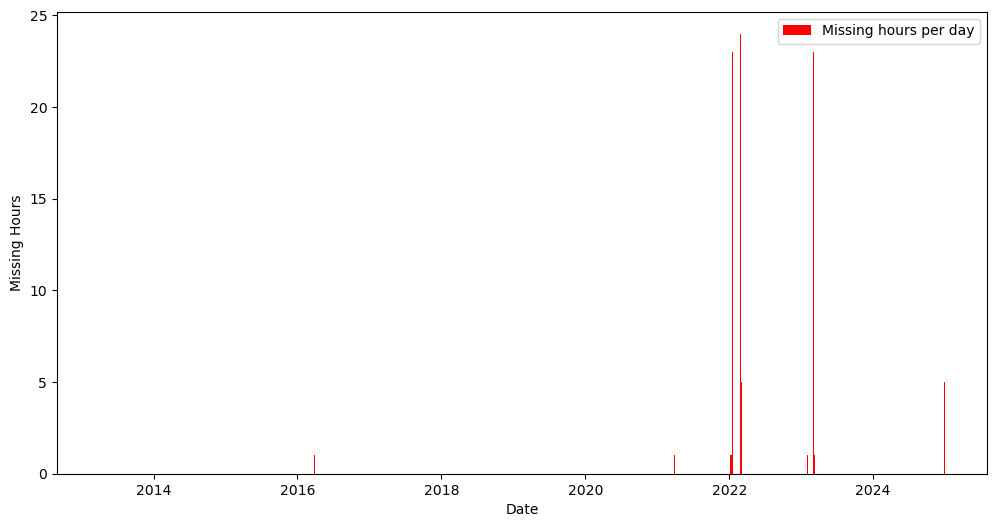

In [9]:
start_date = df.index.min()
end_date = df.index.max()

all_hours = pd.date_range(start=start_date, end=end_date, freq='H')

missing_hours = all_hours.difference(df.index)

missing_df = pd.DataFrame(index=missing_hours, data={'missing': 1})
missing_per_day = missing_df.resample('D').sum()

plt.figure(figsize=(12, 6))
plt.bar(missing_per_day.index, missing_per_day['missing'], color='red', label='Missing hours per day')
plt.xlabel('Date')
plt.ylabel('Missing Hours')
plt.legend()
plt.show()

#### Fill Missing Values

In [10]:
df.index = pd.to_datetime(df.index)

df = df.asfreq('H')

missing_timestamps = df['bike_count'].isna().sum()
print(missing_timestamps)

df['weekofyear'] = df.index.isocalendar().week
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

def interpolate_missing_values(row, df):
    if pd.isna(row['bike_count']):

        mask = (
            (df['weekofyear'] == row['weekofyear']) &
            (df['dayofweek'] == row['dayofweek']) &
            (df['hour'] == row['hour']) &
            (df.index < row.name)
        )
        relevant_values = df.loc[mask, 'bike_count'].dropna()
        
        if not relevant_values.empty:
            return round(relevant_values.mean())
        else:
            return np.nan
    
    return row['bike_count']

df['bike_count'] = df.apply(lambda row: interpolate_missing_values(row, df), axis=1)

379


In [11]:
df["bike_count"].dtype

dtype('float64')

<AxesSubplot:xlabel='Datetime'>

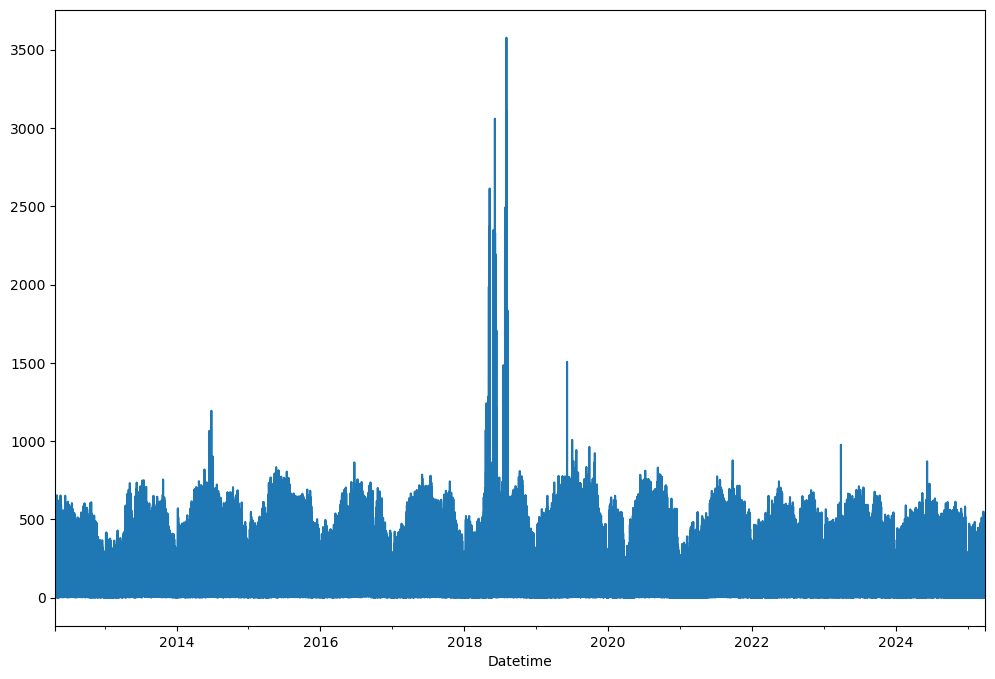

In [12]:
df["bike_count"].plot(figsize=(12,8))

In [13]:
df['bike_count'].fillna(0, inplace=True)

In [14]:
start_date = df.index.min()
end_date = df.index.max()

all_hours = pd.date_range(start=start_date, end=end_date, freq='H')

missing_hours = all_hours.difference(df.index)

missing_count = len(missing_hours)

print(missing_count)
print(missing_hours)

0
DatetimeIndex([], dtype='datetime64[ns, Europe/Berlin]', freq='H')


In [15]:
nan_count = df['bike_count'].isna().sum()
print(nan_count)

0


In [16]:
df = df.drop(columns={"weekofyear", "dayofweek", "hour"})
df = df.rename(columns={"bike_count": "target"})  

df.to_csv("bike_data.csv")